In [3]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#import os 
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [4]:
from keras.datasets import  cifar10

# classification data
nb_classes = 10
batch_size = 128

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if len(x_train.shape) == 3:
    x_train = x_train[:, :, :, np.newaxis]
    x_test = x_test[:, :, :, np.newaxis]

# input image dimensions
img_rows, img_cols, nb_channels = x_train.shape[1:]
dim = img_rows * img_cols * nb_channels
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


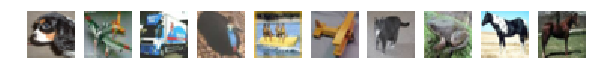

In [5]:
# idx = 
num_samples = 10
idx = np.random.randint(x_train.shape[0], size=num_samples)

fig = plt.figure(figsize=(num_samples, 2))

for i in range(num_samples):
    ax = fig.add_subplot(1, num_samples, i + 1)
    ax.imshow(x_train[idx[i]])
    ax.axis('off')

plt.show()

In [6]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc
from tensorflow.python.ops.nn import conv2d, relu, max_pool, bias_add



def dropout_layer(x, mode, l, dim):

    if mode == 'struc':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        xm = tf.reduce_mean(x, 0)
        cov = tf.matmul(tf.transpose(x-xm), x-xm) / batch_size
        cov += 1e-2 * tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'iid_gauss':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))
    elif mode == 'iid_bern':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )
    else:  # no dropout
        return x



class LeNet5:

    def __init__(self, nb_channels, nb_classes, batch_size, l, mode=None):

        input_size = img_rows

        self.X = tf.placeholder(tf.float32, [None, input_size, input_size, nb_channels])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)
        
        nb_kernels_1 = 8

        W1 = tf.Variable(tf.truncated_normal([3, 3, nb_channels, nb_kernels_1], stddev=0.1))
        b1 = tf.Variable(tf.zeros([nb_kernels_1]))

        self.conv_act1 = relu(bias_add(conv2d(self.X, W1, strides=[1, 1, 1, 1], padding='SAME'), b1))
#         x = max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        nb_kernels_2 = 8

        W2 = tf.Variable(tf.truncated_normal([3, 3, nb_kernels_1, nb_kernels_2], stddev=0.1))
        b2 = tf.Variable(tf.zeros([nb_kernels_2]))

        x = relu(bias_add(conv2d(self.conv_act1, W2, strides=[1, 1, 1, 1], padding='SAME'), b2))
        x = max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
        nb_kernels_3 = 16

        W3 = tf.Variable(tf.truncated_normal([3, 3, nb_kernels_2, nb_kernels_3], stddev=0.1))
        b3 = tf.Variable(tf.zeros([nb_kernels_3]))

        self.conv_act2 = relu(bias_add(conv2d(x, W3, strides=[1, 1, 1, 1], padding='SAME'), b3))
#         x = max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        nb_kernels_4 = 16

        W4 = tf.Variable(tf.truncated_normal([3, 3, nb_kernels_3, nb_kernels_4], stddev=0.1))
        b4 = tf.Variable(tf.zeros([nb_kernels_4]))

        x = relu(bias_add(conv2d(self.conv_act2, W4, strides=[1, 1, 1, 1], padding='SAME'), b4))
        x = max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#         nb_kernels_1 = 6

#         W1 = tf.Variable(tf.truncated_normal([5, 5, nb_channels, nb_kernels_1], stddev=0.1))
#         b1 = tf.Variable(tf.zeros([nb_kernels_1]))

#         x = relu(bias_add(conv2d(self.X, W1, strides=[1, 1, 1, 1], padding='SAME'), b1))
#         x = max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#         nb_kernels_2 = 16

#         W2 = tf.Variable(tf.truncated_normal([5, 5, nb_kernels_1, nb_kernels_2], stddev=0.1))
#         b2 = tf.Variable(tf.constant(0.1, shape=[nb_kernels_2]))

#         x = relu(bias_add(conv2d(x, W2, strides=[1, 1, 1, 1], padding='SAME'), b2))
#         x = max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        x_shape = tf.shape(x)
        vector_dim = x_shape[1] * x_shape[2] * x_shape[3]
        x = tf.reshape(x, [x_shape[0], vector_dim])

        nb_fc_1 = 1024

        W5 = tf.Variable(tf.random_uniform([input_size//4 * input_size//4 * nb_kernels_4, nb_fc_1], -0.01, 0.01))
        b5 = tf.Variable(tf.zeros(shape=[nb_fc_1]))

        #self.dl0 = tf.cond(self.train, lambda : dropout_layer(x, mode, l,input_size//4 * input_size//4 * nb_kernels_4), lambda : x)
        self.dl0=x
        self.act0 = tf.nn.relu(tf.matmul(self.dl0, W5) + b5)
        #x = tf.nn.relu(tf.matmul(x, W5) + b5)

        nb_fc_2 = 10
        
        W6 = tf.Variable(tf.random_uniform([nb_fc_1, nb_fc_2], -0.01, 0.01))
        b6 = tf.Variable(tf.zeros(shape=[nb_fc_2]))

        #self.dl1 = tf.cond(self.train, lambda : dropout_layer(self.act0, mode, l, nb_fc_1), lambda : self.act0)
        self.dl1 = self.act0
        self.act1 = tf.nn.relu(tf.matmul(self.dl1, W6) + b6)

        nb_class = 10     
        
        W7 = tf.Variable(tf.random_uniform([nb_fc_2, nb_class], -0.01, 0.01))
        b7 = tf.Variable(tf.zeros(shape=[nb_class]))

        self.dl2 = tf.cond(self.train, lambda : dropout_layer(self.act1, mode, l, nb_fc_2), lambda : self.act1)
        #self.dl2=self.act1
        self.act2= tf.matmul(self.dl2, W7) + b7

        # Minimize error using cross entropy
        self.probs = tf.nn.softmax(self.act2)
        log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.act2, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [ ]:
def training(seqlambda, mode, max_iters=4000, learning_rate=1):

    all_accuracies = []
    all_cov_norms1 = []
    all_cov_norms2 = []
    all_cov_norms3 = []
    acts1 = []
    acts2 = []
    conv_acts1 = []
    conv_acts2 = []

    for lamb in seqlambda:

        print('Lambda', lamb)
        accs = [] ; cov_norms1 = [] ; cov_norms2 = [] ; cov_norms3 = []

#         model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
#         model = MLP(dim, nb_hidden, nb_classes, batch_size, lamb, mode)
        model = LeNet5(nb_channels, nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss = sess.run([optimiser, model.mean_log_loss], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred, act1, act2, conv_act1,conv_act2, dl1,dl2 = sess.run([model.probs, model.act0, model.act1,model.conv_act1,model.conv_act2,model.dl1,model.dl2], 
                                    feed_dict={model.X : x_test, model.train : False})
                    #print(np.sum(err1))
                    #print(np.sum(err2))
                    acc = np.sum(np.argmax(pred, axis=1) == 
                                 np.argmax(y_test, axis=1)) / float(nb_test)
                    accs.append(acc)
                    cov_norms1.append(np.linalg.norm(np.corrcoef((dl1 + 1e-8 * np.random.rand(*dl1.shape)).T)))
                    cov_norms2.append(np.linalg.norm(np.corrcoef((dl2 + 1e-8 * np.random.rand(*dl2.shape)).T)))
                    print('Accuracy: %.03f' % acc)
            all_accuracies.append(accs)
            all_cov_norms1.append(cov_norms1)
            all_cov_norms2.append(cov_norms2)
        acts1.append(act1)
        acts2.append(act2)
        conv_acts1.append(conv_act1)
        conv_acts2.append(conv_act2)        
    return all_accuracies, all_cov_norms1, all_cov_norms2, acts1, acts2, conv_acts1,conv_acts2

max_iters = 10000
lambdas = [1e-6,1e-4,1e-2,1e-0]

#1e-5,1e-4,1e-3,1e-2,1e-1,

print('#### No dropout ####')
acc_linear, cov_norms1_linear, cov_norms2_linear,act1_linear,act2_linear, conv_act1_linear, conv_act2_linear = training([None], None, max_iters)

print('#### Structured dropout ####')
acc_struc, cov_norms1_struc, cov_norms2_struc,act1_struc,act2_struc, conv_act1_struc, conv_act2_struc  = training(lambdas, 'struc', max_iters)
    
print('#### IID gauss dropout ####')
acc_iid, cov_norms1_iid, cov_norms2_iid,act1_iid,act2_iid , conv_act1_iid, conv_act2_iid= training(lambdas, 'iid_gauss', max_iters)

print('#### IID bern dropout ####')
acc_iid_bern, cov_norms1_iid_bern, cov_norms2_iid_bern,act1_iid_bern,act2_iid_bern , conv_act1_iid_bern, conv_act2_iid_bern= training(lambdas, 'iid_bern', max_iters)

#### No dropout ####
Lambda None
Iteration: 0, 2.303
Accuracy: 0.100
Iteration: 200, 1.979
Accuracy: 0.231
Iteration: 400, 1.810


In [ ]:
sns.reset_orig()

lambdas = [1e-6,1e-4,1e-2,1e-0]

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), acc_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','--+','-',':']

for i, series in enumerate(acc_struc):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_iid):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='green', linewidth=1,
            label=r'iid gauss drop. $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_iid_bern):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='purple', linewidth=1,
            label=r'iid bern. drop. $\lambda=$%.0e' % lambdas[i])
    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 18})
plt.show()

In [ ]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), acc_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no dropout')

line_styles = ['--o', '--*', '--']


best_iid = np.argmax([np.max(accs) for accs in acc_iid])

ax.plot(np.arange(200, max_iters, 200), acc_iid[best_iid][1:],
            line_styles[1], color='green', linewidth=1,
            label=r'iid. Gauss. dropout, $\lambda=$%.0e' % lambdas[best_iid])

best_iid_bern = np.argmax([np.max(accs) for accs in acc_iid_bern])

ax.plot(np.arange(200, max_iters, 200), acc_iid_bern[best_iid_bern][1:],
            line_styles[1], color='purple', linewidth=1,
            label=r'iid. Bern. dropout, $\lambda=$%.0e' % lambdas[best_iid_bern])

best_struc = np.argmax([np.max(accs) for accs in acc_struc])

ax.plot(np.arange(200, max_iters, 200), acc_struc[best_struc][1:],
            line_styles[1], color='blue', linewidth=1,
            label=r'struc. Gauss. drop. (ASNI), $\lambda=$%.0e' % lambdas[best_struc])


ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

plt.legend(prop={'size': 18})
plt.show()

In [ ]:
[np.max(accs) for accs in acc_linear]

In [ ]:
[np.max(accs) for accs in acc_iid]

In [ ]:
[np.max(accs) for accs in acc_iid_bern]

In [ ]:
[np.max(accs) for accs in acc_struc]

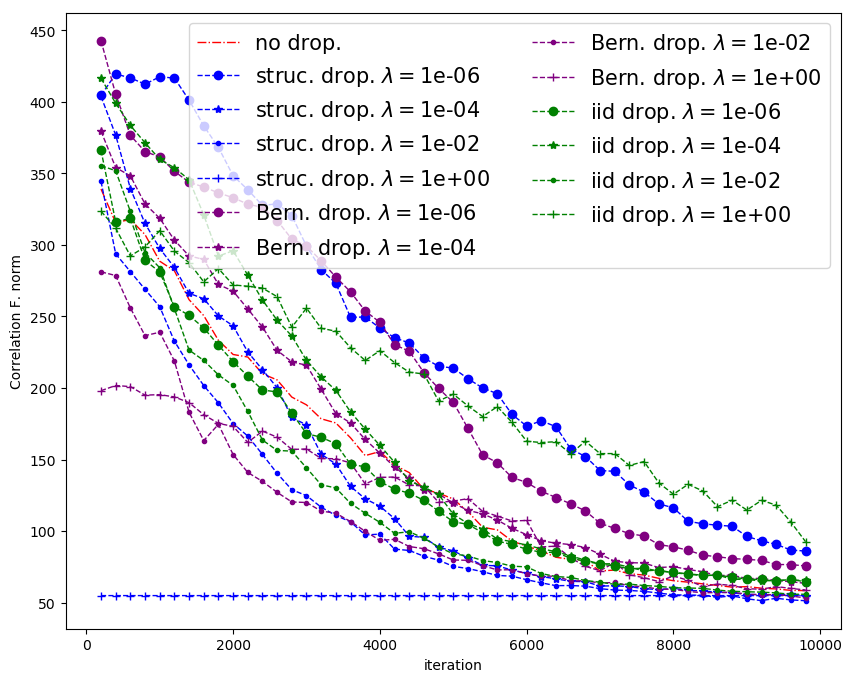

In [107]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), cov_norms1_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','--+',':']

for i, series in enumerate(cov_norms1_struc):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])
    
for i, series in enumerate(cov_norms1_iid_bern):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='purple', linewidth=1,
            label=r'Bern. drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(cov_norms1_iid):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='green', linewidth=1,
            label=r'iid drop. $\lambda=$%.0e' % lambdas[i])

ax.set_xlabel('iteration')
ax.set_ylabel('Correlation F. norm')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 15})
plt.show()

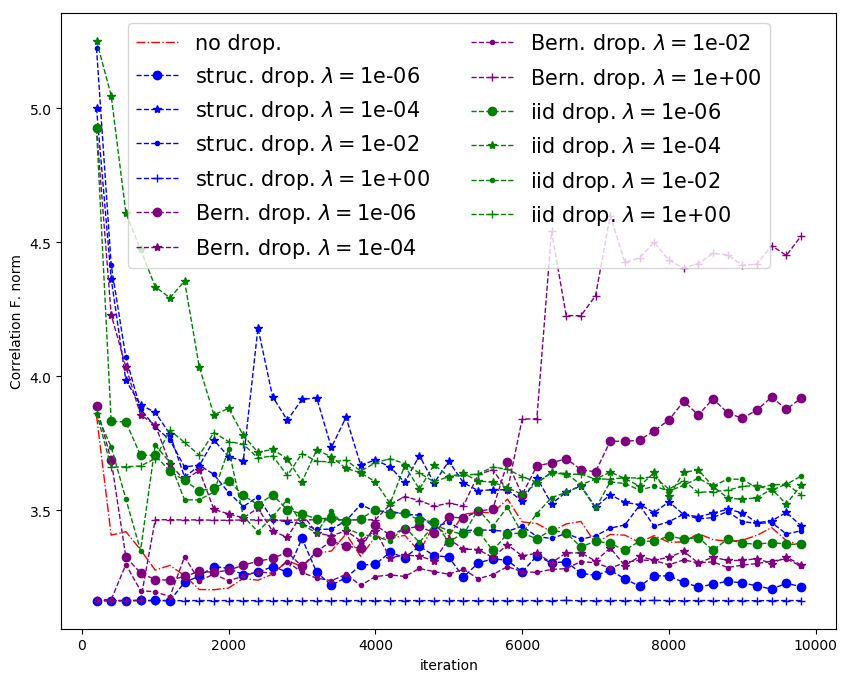

In [108]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), cov_norms2_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','--+',':']

for i, series in enumerate(cov_norms2_struc):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])
    
for i, series in enumerate(cov_norms2_iid_bern):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='purple', linewidth=1,
            label=r'Bern. drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(cov_norms2_iid):
    ax.plot(np.arange(200, max_iters, 200), series[1:],
            line_styles[i], color='green', linewidth=1,
            label=r'iid drop. $\lambda=$%.0e' % lambdas[i])

ax.set_xlabel('iteration')
ax.set_ylabel('Correlation F. norm')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 15})
plt.show()

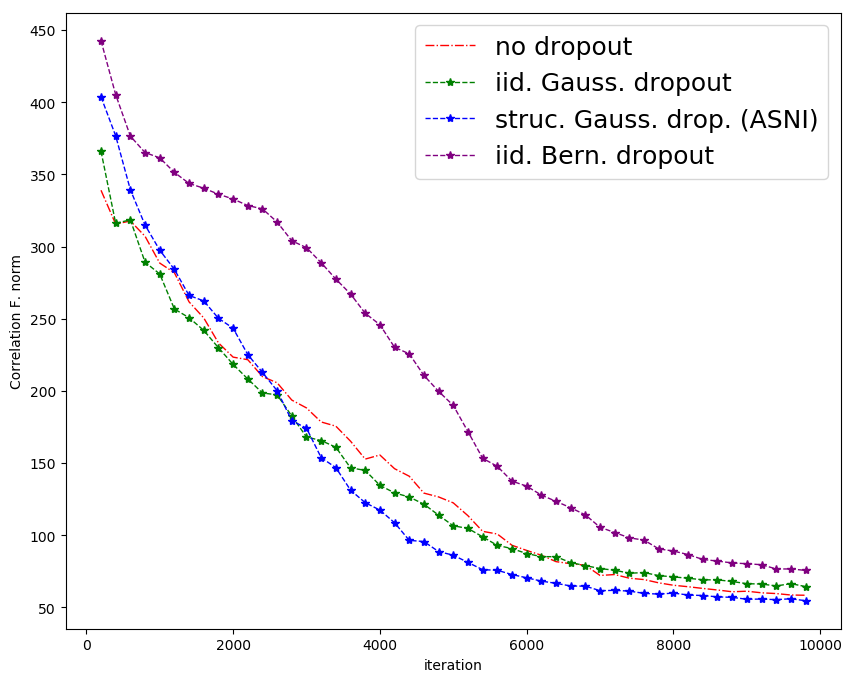

In [111]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), cov_norms1_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no dropout')

line_styles = ['--o', '--*', '--.']


best_iid = np.argmax([np.max(accs) for accs in acc_iid])

ax.plot(np.arange(200, max_iters, 200), cov_norms1_iid[best_iid][1:],
            line_styles[1], color='green', linewidth=1,
            label=r'iid. Gauss. dropout' )

best_struc = np.argmax([np.max(accs) for accs in acc_struc])

ax.plot(np.arange(200, max_iters, 200), cov_norms1_struc[best_struc][1:],
            line_styles[1], color='blue', linewidth=1,
            label=r'struc. Gauss. drop. (ASNI)')


best_iid_bern = np.argmax([np.max(accs) for accs in acc_iid_bern])

ax.plot(np.arange(200, max_iters, 200), cov_norms1_iid_bern[best_iid_bern][1:],
            line_styles[1], color='purple', linewidth=1,
            label=r'iid. Bern. dropout' )


ax.set_xlabel('iteration')
ax.set_ylabel('Correlation F. norm')

# ax.set_ylim([0.8, 1.0])

plt.legend(prop={'size': 18})
plt.show()

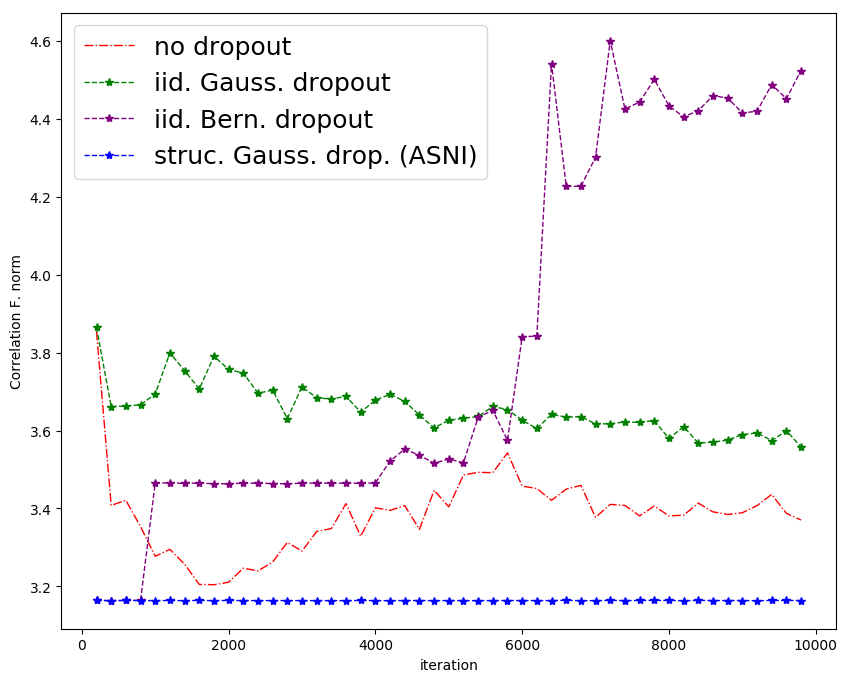

In [113]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(200, max_iters, 200), cov_norms2_linear[0][1:], linestyle='-.',
        linewidth=1, color='red', label='no dropout')

line_styles = ['--o', '--*', '--.']


best_iid = np.argmax([np.max(accs) for accs in acc_iid])

ax.plot(np.arange(200, max_iters, 200), cov_norms2_iid[-1][1:],
            line_styles[1], color='green', linewidth=1,
            label=r'iid. Gauss. dropout' )

best_iid_bern = np.argmax([np.max(accs) for accs in acc_iid_bern])

ax.plot(np.arange(200, max_iters, 200), cov_norms2_iid_bern[-1][1:],
            line_styles[1], color='purple', linewidth=1,
            label=r'iid. Bern. dropout' )


best_struc = np.argmax([np.max(accs) for accs in acc_struc])

ax.plot(np.arange(200, max_iters, 200), cov_norms2_struc[-1][1:],
            line_styles[1], color='blue', linewidth=1,
            label=r'struc. Gauss. drop. (ASNI)')



ax.set_xlabel('iteration')
ax.set_ylabel('Correlation F. norm')

# ax.set_ylim([0.8, 1.0])

plt.legend(prop={'size': 18})
plt.show()

In [145]:
from sklearn.manifold import TSNE

model = TSNE()
embedding_linear = model.fit_transform(act1_linear[-1][:1000, :])
embedding_linear_2 = model.fit_transform(act2_linear[-1][:1000, :])
embedding_iid = model.fit_transform(act1_iid[-1][:1000, ])
embedding_iid_2 = model.fit_transform(act2_iid[-1][:1000, ])
embedding_struc = model.fit_transform(act1_struc[-1][:1000, ])
embedding_struc_2 = model.fit_transform(act2_struc[-1][:1000, ])
embedding_iid_bern = model.fit_transform(act1_iid[-1][:1000, ])
embedding_iid_2_bern = model.fit_transform(act2_iid[-1][:1000, ])

In [146]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


 # tsne = TSNE(n_components=2)
    # tsne.fit(encoding)


n_clusters=10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(embedding_linear,  y_test[:1000])
print("For the model withoud dropout",
      "The average silhouette_score for the first layer is :", silhouette_avg)

silhouette_avg = silhouette_score(embedding_iid,  y_test[:1000])
print("For model with iid noise injection and lambda = ", lambdas[best_iid],
      "The average silhouette_score for the first layer is :", silhouette_avg)


silhouette_avg = silhouette_score(embedding_struc,  y_test[:1000])
print("For model with structured noise injection and lambda = ", lambdas[best_struc],
      "The average silhouette_score for the first layer is :", silhouette_avg)



n_clusters=10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(embedding_linear_2,  y_test[:1000])
print("For the model withoud dropout",
      "The average silhouette_score for the second layer is :", silhouette_avg)

silhouette_avg = silhouette_score(embedding_iid_2,  y_test[:1000])
print("For model with iid noise injection and lambda = ", lambdas[best_iid],
      "The average silhouette_score for the second layer is :", silhouette_avg)


silhouette_avg = silhouette_score(embedding_struc_2,  y_test[:1000])
print("For model (ASNI) and lambda = ", lambdas[best_struc],
      "The average silhouette_score for the second layer is :", silhouette_avg)


/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed

For the model withoud dropout The average silhouette_score for the first layer is : -0.057597168
For model with iid noise injection and lambda =  1e-06 The average silhouette_score for the first layer is : -0.08573385
For model with structured noise injection and lambda =  0.0001 The average silhouette_score for the first layer is : -0.13050996
For the model withoud dropout The average silhouette_score for the second layer is : 0.006969362
For model with iid noise injection and lambda =  1e-06 The average silhouette_score for the second layer is : -0.07608653
For model (ASNI) and lambda =  0.0001 The average silhouette_score for the second layer is : -0.063736804


/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


For n_clusters = 10 The average silhouette_score is : 0.36872622


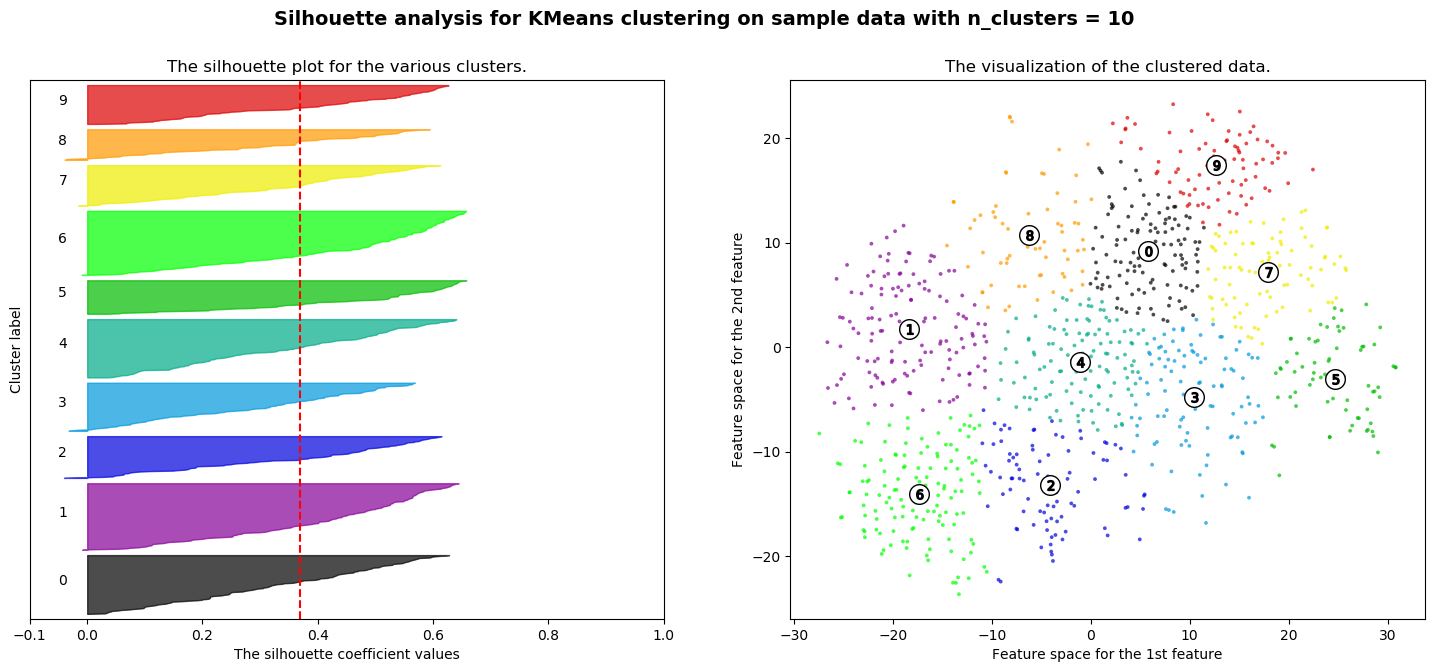

In [147]:

range_n_clusters=[10] 


X=embedding_linear
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
range_n_clusters=[10] 


X=embedding_iid
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


For n_clusters = 10 The average silhouette_score is : 0.39089552


In [ ]:
range_n_clusters=[10] 


X=embedding_iid_bern
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:

range_n_clusters=[10] 


X=embedding_struc
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:

range_n_clusters=[10] 


X=embedding_linear_2
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:

range_n_clusters=[10] 


X=embedding_iid_2
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
range_n_clusters=[10] 


X=embedding_iid_2_bern
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:

range_n_clusters=[10] 


X=embedding_struc_2
y=y_test


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

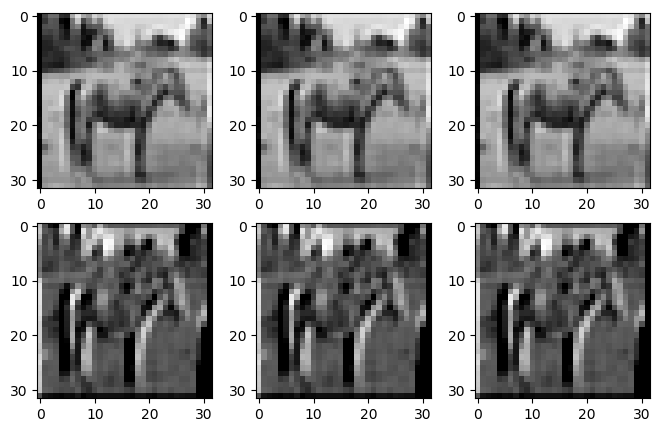

In [124]:
fig, axes = plt.subplots(figsize=(8, 5), nrows=2, ncols=3)

for i in range(2):
    for j in range(3):
        axes[i][j].imshow(conv_act1_linear[-1][-1, :, :, i], cmap='Greys_r')

plt.show()


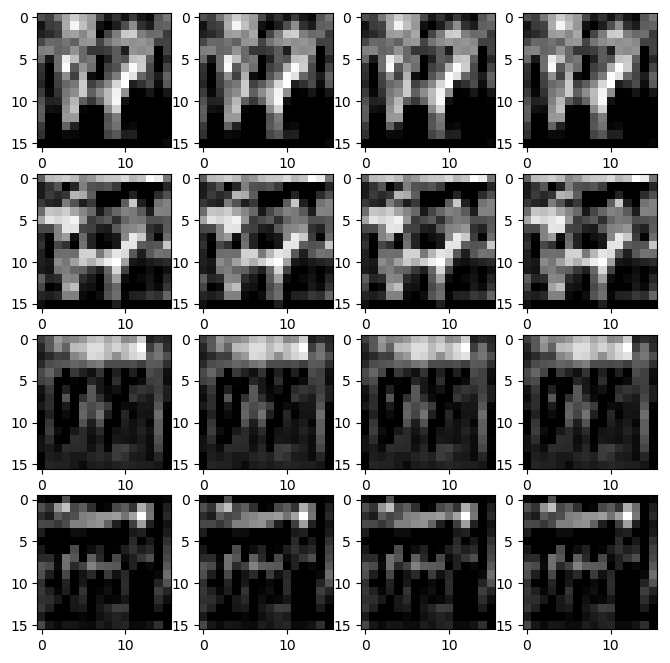

In [125]:

fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act2_linear[-1][-1, :, :, i], cmap='Greys_r')

plt.show()

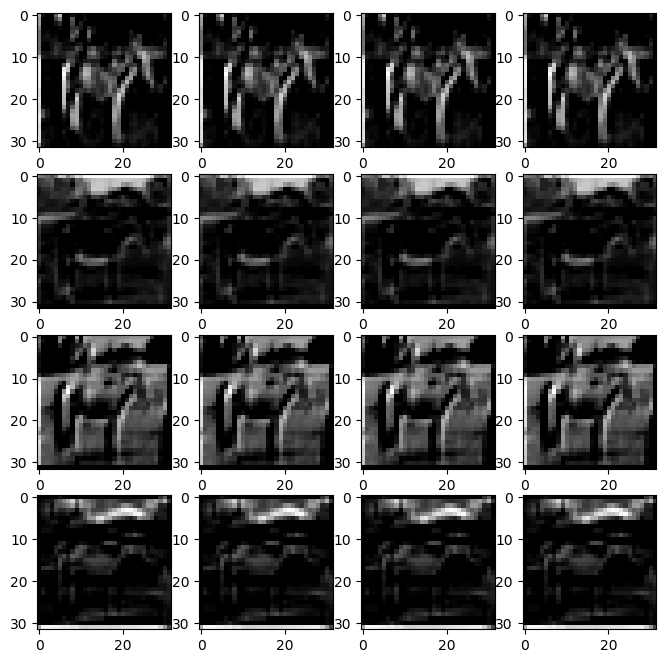

In [135]:


fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act1_iid[-1][-1, :, :, i], cmap='Greys_r')


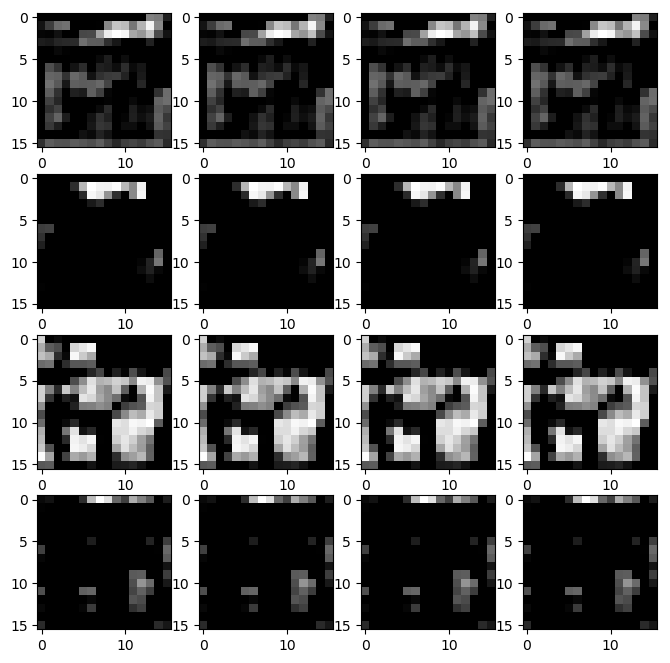

In [127]:

fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act2_iid[-1][-1, :, :, i], cmap='Greys_r')

plt.show()

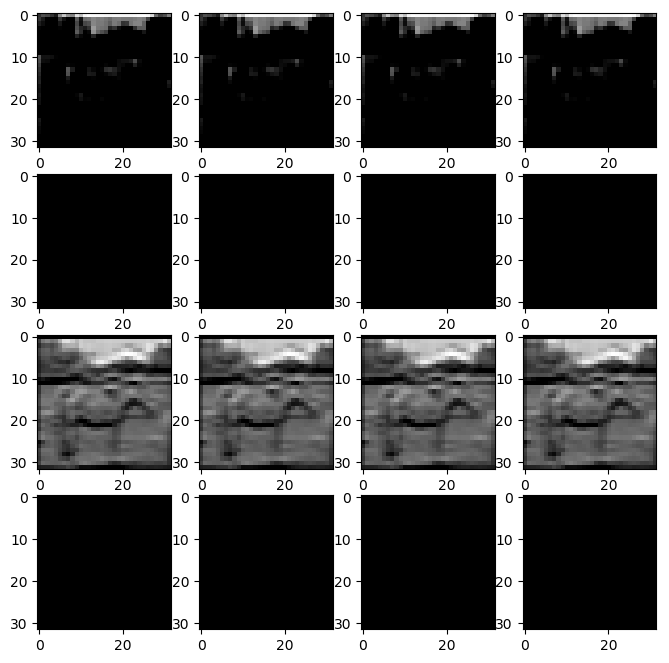

In [134]:


fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act1_iid_bern[-1][-1, :, :, i], cmap='Greys_r')
plt.show()

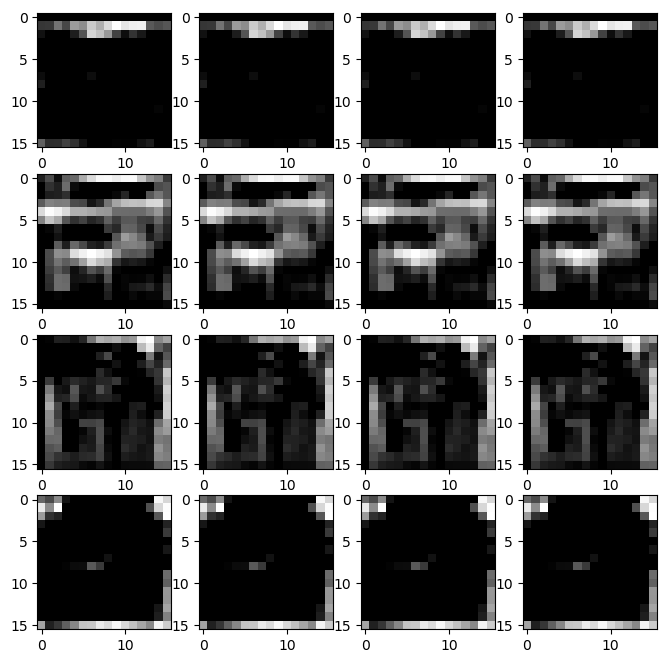

In [143]:


fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act2_iid_bern[-1][-1, :, :, i], cmap='Greys_r')
plt.show()

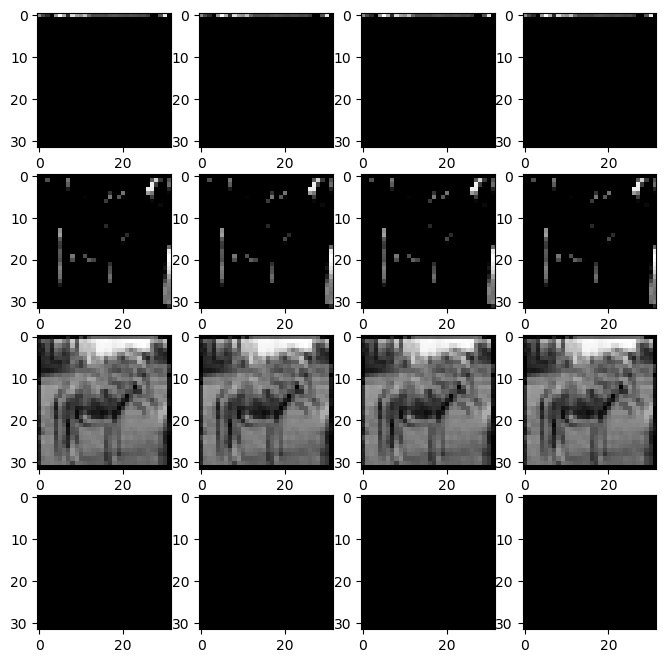

In [141]:
fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act1_struc[-1][-1, :, :, i], cmap='Greys_r')
plt.show()

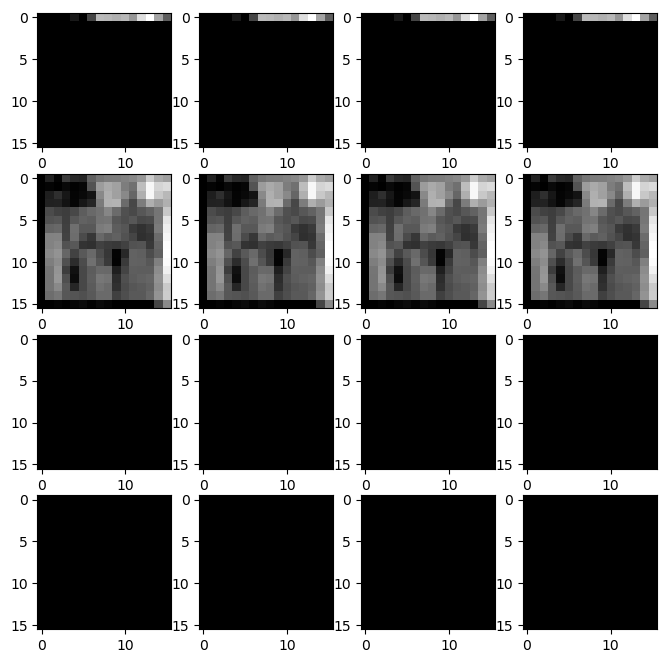

In [144]:
fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for i in range(4):
    for j in range(4):
        axes[i][j].imshow(conv_act2_struc[-1][-1, :, :, i], cmap='Greys_r')
plt.show()